In [1]:
import numpy as np

import torch
from torch import nn
from torch import optim

import tqdm

import tkinter

from IPython.display import clear_output

In [2]:
torch.cuda.empty_cache()

In [3]:
import sys
sys.path.append('..')

from samplers_new import mala, i_sir, ex2_mcmc

In [4]:
torch.cuda.is_available()

True

In [5]:
from cifar10_experiments.models import Generator, Discriminator

In [6]:
device = torch.device('cuda:0')
lat_size=128

In [7]:
#!pip install tensorrt

In [8]:
from torch_mimicry.nets import sngan

2023-05-29 19:29:58.305274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 19:29:58.743869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
gen_cifar10 = sngan.SNGANGenerator32().to(device)
gen_cifar10.to(device)

discr_cifar10 =  sngan.SNGANDiscriminator32().to(device)
discr_cifar10.to(device)

prior_cifar10 = torch.distributions.MultivariateNormal(torch.zeros(lat_size).to(device), torch.eye(lat_size).to(device))

In [10]:
gen_cifar10.load_state_dict(torch.load('./weights/SNGAN_JS/netG.pth', map_location='cuda:0')['model_state_dict'])
d = torch.load('./weights/SNGAN_JS/netD.pth', map_location='cuda:0')['model_state_dict']
#d = {k:0.9 * v for k, v in d.items()}
discr_cifar10.load_state_dict(d)
gen_cifar10.eval()
discr_cifar10.eval();

In [11]:
def get_energy_wgan(z):
    return -10 * discr_cifar10(gen_cifar10(z)).reshape(z.shape[0]) - prior_cifar10.log_prob(z)

def log_target_dens(z, detach=True, batch_size=256):
    """
    returns the value of a target density - mixture of the 3 gaussians 
    """
    res = []
    for i in range(z.shape[0] // batch_size + (1 if z.shape[0] % batch_size else 0)):
        cur_res = -get_energy_wgan(z[batch_size * i: batch_size * (i+1)])
        
        if detach:
            cur_res = cur_res.detach()
        
        res.append(cur_res)
    
    return torch.cat(res)

In [12]:
log_target_dens(torch.randn(100, lat_size).to(device)).std()

tensor(9.6905, device='cuda:0')

# Put parameters of the target density

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
seed = 43
torch.manual_seed(43)

N_samples=10

x0 = torch.randn(N_samples, lat_size).to(device)

In [15]:
x0.shape

torch.Size([10, 128])

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 10.70it/s]


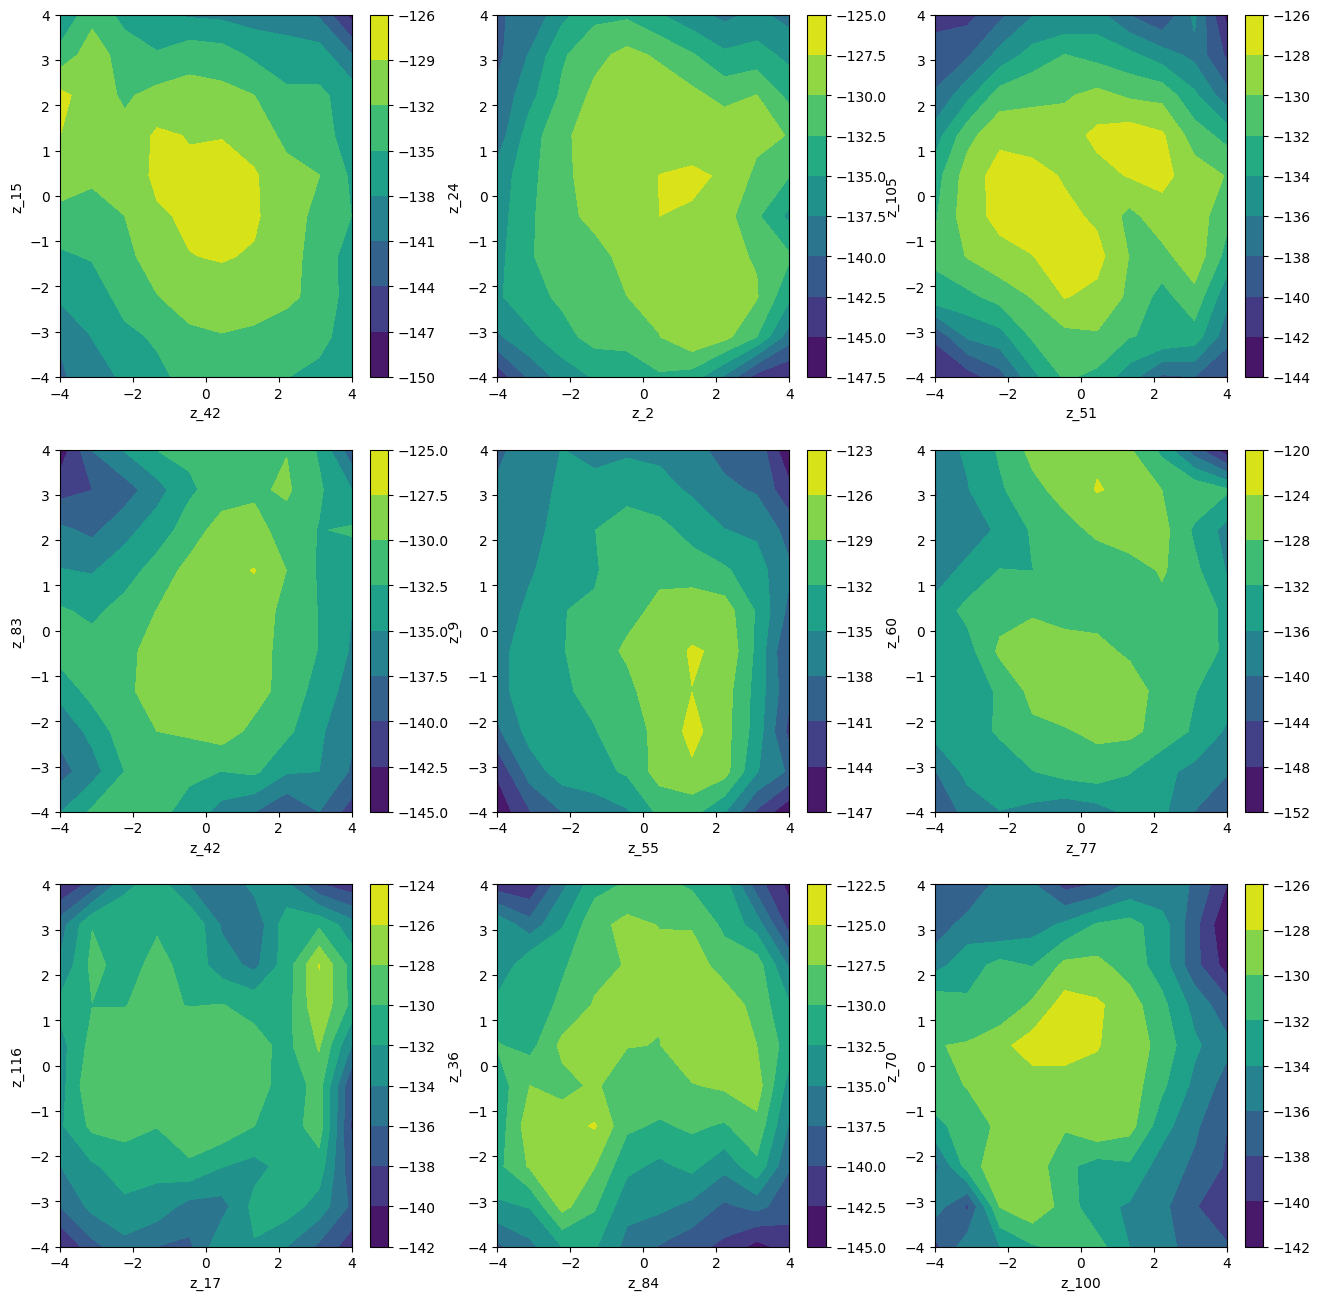

In [16]:
a = 2

plt.figure(figsize=(16, 16))

idxs = []
dens = []

for j in tqdm.tqdm(range(9)):
    idxs_perm = np.random.permutation(np.arange(lat_size))
    
    i1 = idxs_perm[0]
    i2 = idxs_perm[1]
    
    c1 = torch.zeros(lat_size).to(device)
    c1[i1] = 1

    c2 = torch.zeros(lat_size).to(device)
    c2[i2] = 1

    idxs.append((i1, i2))
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)
    points = np.zeros((X.shape[0],X.shape[1], 2),dtype=float)
    points[:, :, 0] = X
    points[:, :, 1] = Y

    points = points.reshape(-1, 2)
    points = torch.FloatTensor(points).to(device)
    
    z = points @ torch.stack((c1, c2))
    
    dens_vals = log_target_dens(z).detach().cpu().numpy()
    
    dens_vals = dens_vals.reshape(N_pts, N_pts)
    
    dens.append(dens_vals)

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

# I-SIR

In [17]:
from torch.distributions import MultivariateNormal

sigma_isir = 1.0
isir_proposal = MultivariateNormal(
    torch.zeros(lat_size).to(device), 
    (sigma_isir ** 2) * torch.eye(lat_size).to(device))

N_particles = 10
N_steps = 100

Samples_isir = i_sir(log_target_dens=log_target_dens, x0=x0, N_steps=N_steps, N_part=N_particles, isir_proposal=isir_proposal)

energies_isir = -log_target_dens(Samples_isir.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 14.29it/s]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 28.42it/s]


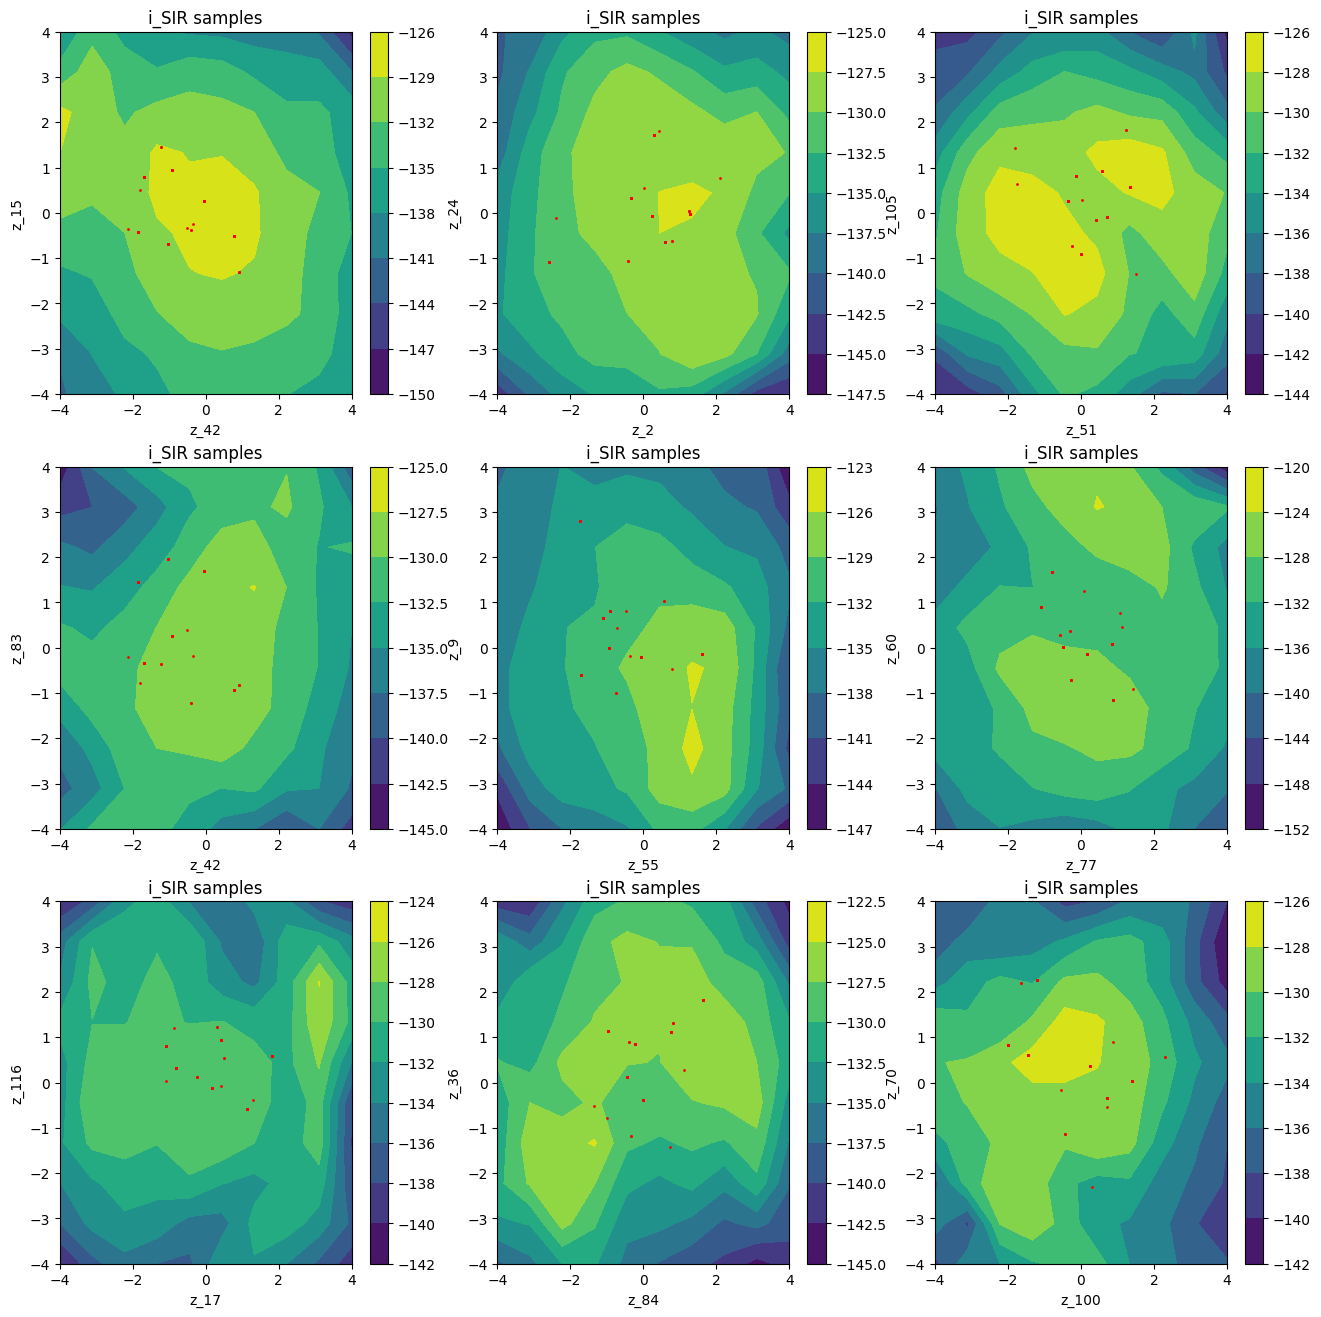

In [18]:
a = 2

plt.figure(figsize=(16, 16))

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.scatter(Samples_isir[0, :, i1].cpu().numpy(), Samples_isir[0, :, i2].cpu().numpy(), s=1, c='r')
    plt.title('i_SIR samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

In [19]:
type(Samples_isir)

torch.Tensor

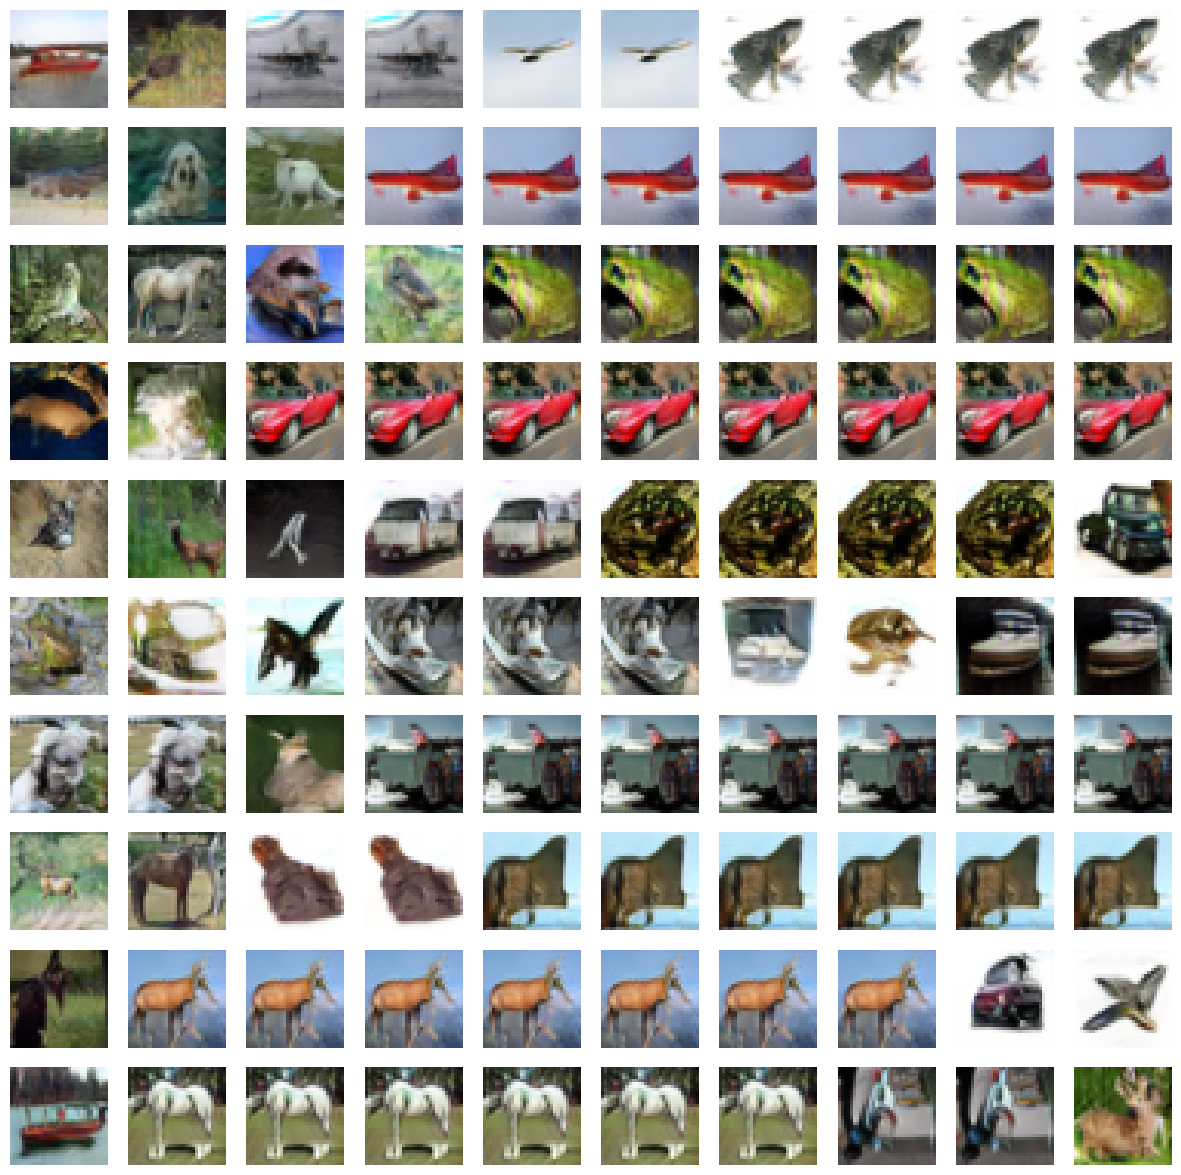

In [20]:
plt.figure(figsize=(15, 15))

Samples_isir = Samples_isir.to(device)

for traj_i in range(10):
    for step_i in range(10):
        plt.subplot(10, 10, 10 * traj_i + step_i + 1)
        #img = gen_cifar10(torch.randn(1, 128))[0].detach().cpu().numpy()
        img = gen_cifar10(Samples_isir[traj_i, step_i * 10:step_i * 10 + 1])[0].detach().cpu().numpy()
        img = (img + 1) / 2
        
        plt.axis('off')
        plt.imshow(img.transpose((1, 2, 0)))

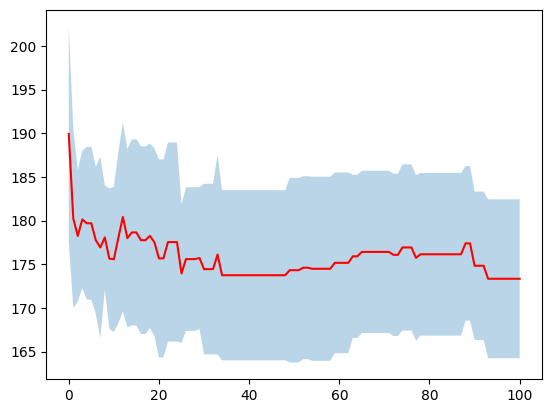

In [21]:
means = energies_isir.mean(dim=0)
stds = energies_isir.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='r')
plt.fill_between(np.arange(N_steps + 1), means - stds, means + stds, alpha=0.3)

# MALA

In [22]:
#N_steps = 100

gamma = 1e-3
mala_iters = 3

stats = {'n_accepts': 0, 'sizes' : 0}

Samples_mala = mala(log_target_dens=log_target_dens, x0=x0, N_steps=N_steps, gamma=gamma,
                    mala_iters=mala_iters, stats=stats)

energies_mala = -log_target_dens(Samples_mala.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.74it/s]


In [23]:
stats['n_accepts']/stats['sizes']

0.7216666666666667

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 43.40it/s]


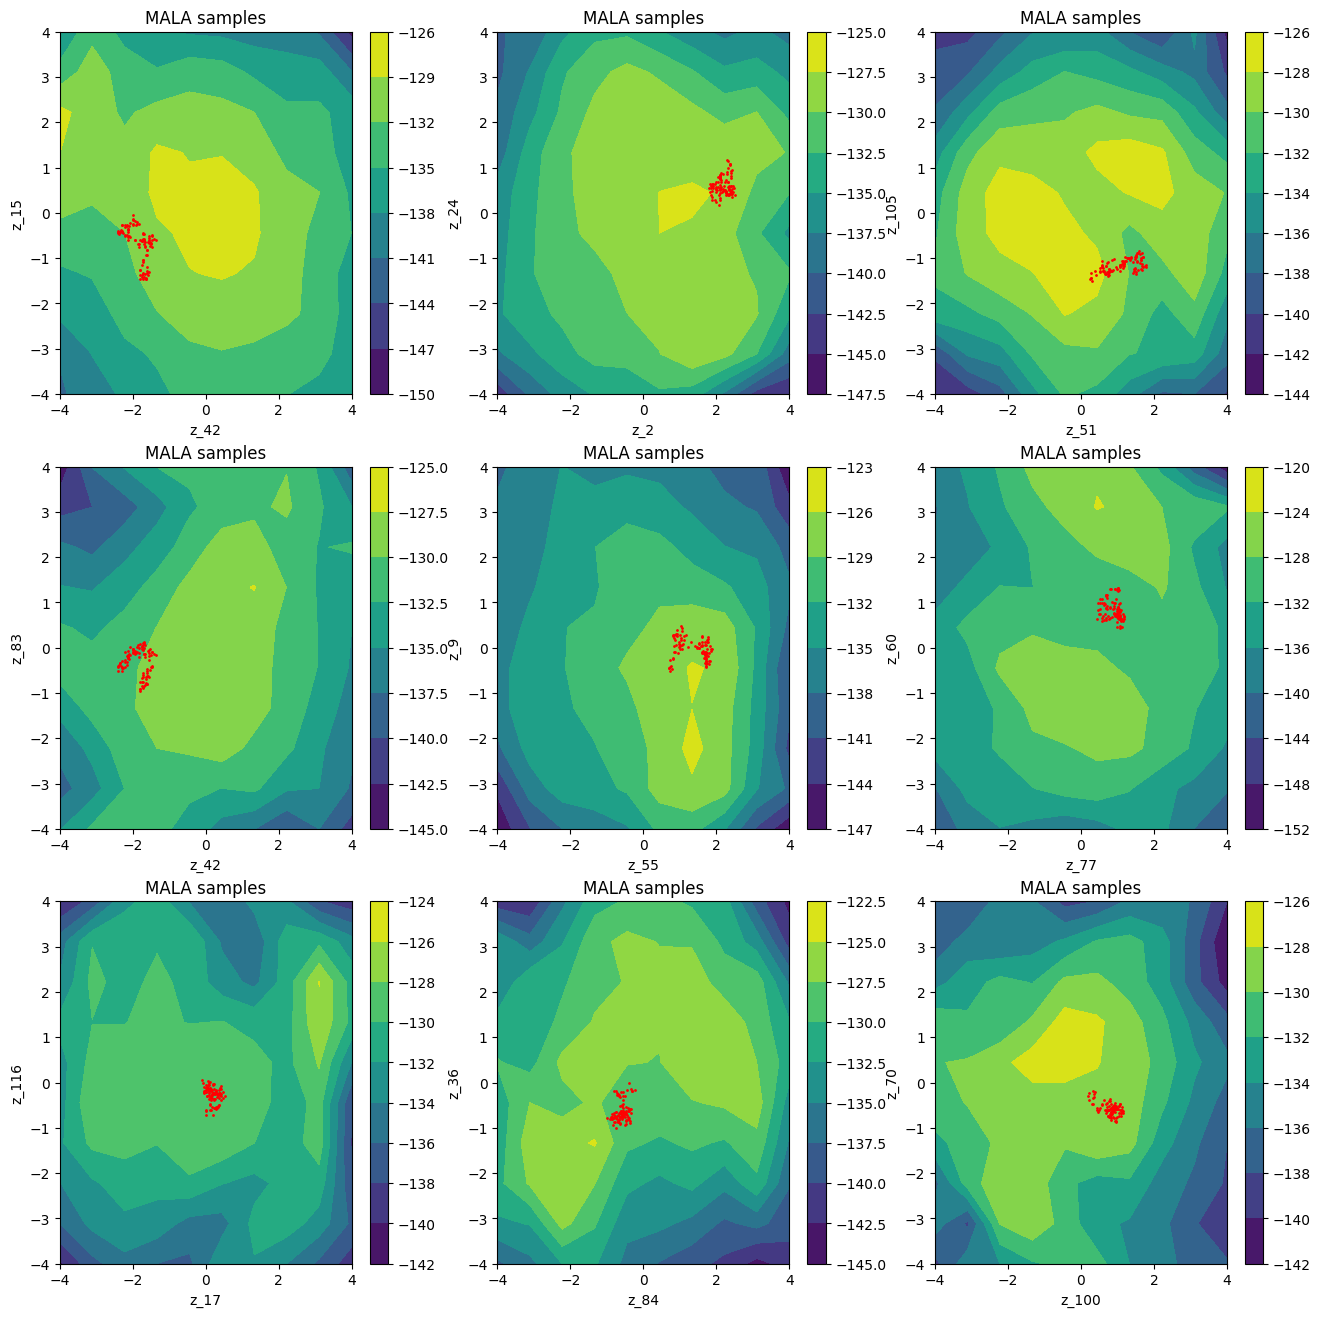

In [24]:
a = 2

plt.figure(figsize=(16, 16))

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.scatter(Samples_mala[0, :, i1].cpu().numpy(), Samples_mala[0, :, i2].cpu().numpy(), s=1, c='r')
    plt.title('MALA samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

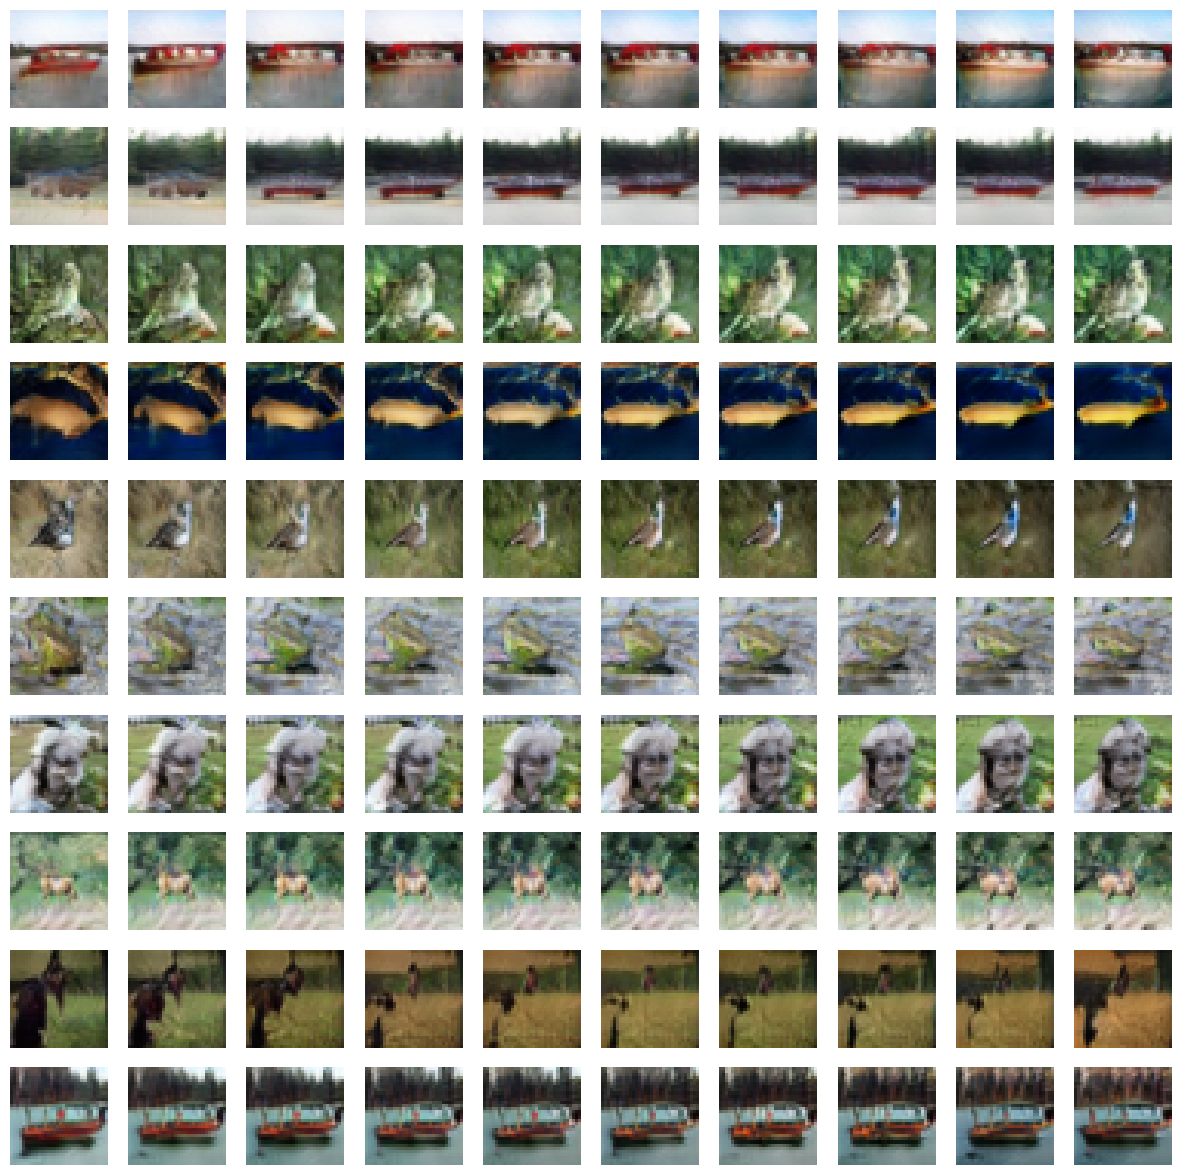

In [25]:
plt.figure(figsize=(15, 15))

for traj_i in range(10):
    for step_i in range(10):
        plt.subplot(10, 10, 10 * traj_i + step_i + 1)
        img = gen_cifar10(Samples_mala[traj_i, step_i * 10:step_i * 10 + 1])[0].detach().cpu().numpy()
        img = (img + 1) / 2
        
        plt.axis('off')
        plt.imshow(img.transpose((1, 2, 0)))

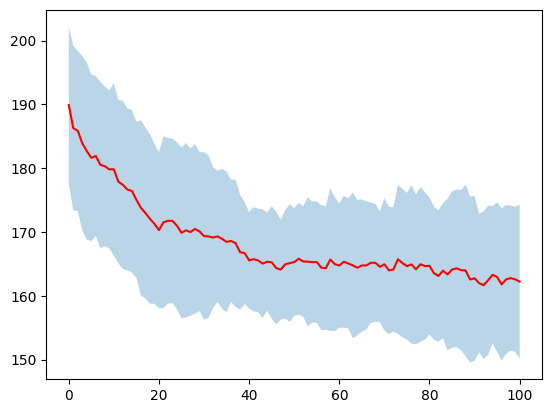

In [26]:
means = energies_mala.mean(dim=0)
stds = energies_mala.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='r')
plt.fill_between(np.arange(N_steps + 1), means - stds, means + stds, alpha=0.3)

In [27]:
Samples_mala.shape

torch.Size([10, 101, 128])

# Ex2MCMC

In [28]:
#N_steps = 100

sigma_isir = 1.0
isir_proposal = MultivariateNormal(
    torch.zeros(lat_size).to(device), 
    (sigma_isir ** 2) * torch.eye(lat_size).to(device))

N_particles = 10

gamma = 5e-3
mala_iters = 3

stats = {'n_accepts': 0, 'sizes':0}

Samples_ex2 = ex2_mcmc(log_target_dens=log_target_dens, x0=x0, N_steps=N_steps, 
                       N_part=N_particles, isir_proposal=isir_proposal ,
                       gamma=gamma, mala_iters=mala_iters, stats=stats)

energies_ex2 = -log_target_dens(Samples_ex2.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


In [29]:
stats['n_accepts']/stats['sizes']

0.163

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 23.85it/s]


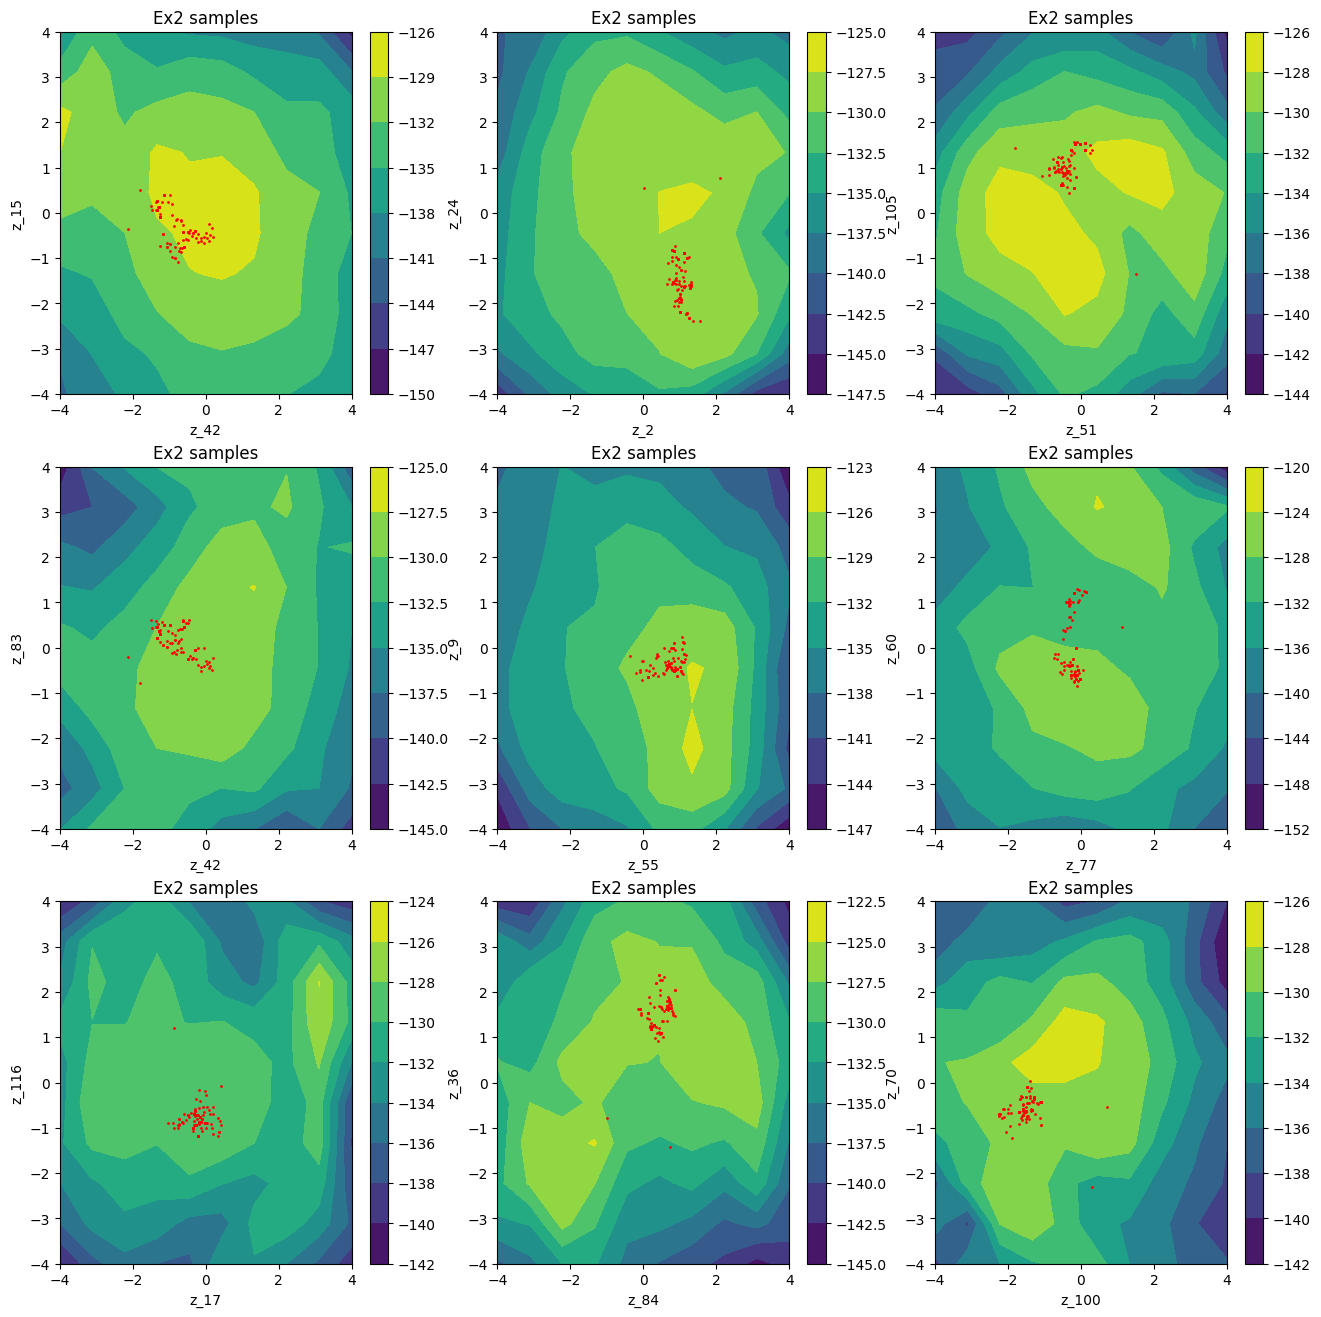

In [30]:
a = 2

plt.figure(figsize=(16, 16))

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.scatter(Samples_ex2[0, :, i1].cpu().numpy(), Samples_ex2[0, :, i2].cpu().numpy(), s=1, c='r')
    plt.title('Ex2 samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

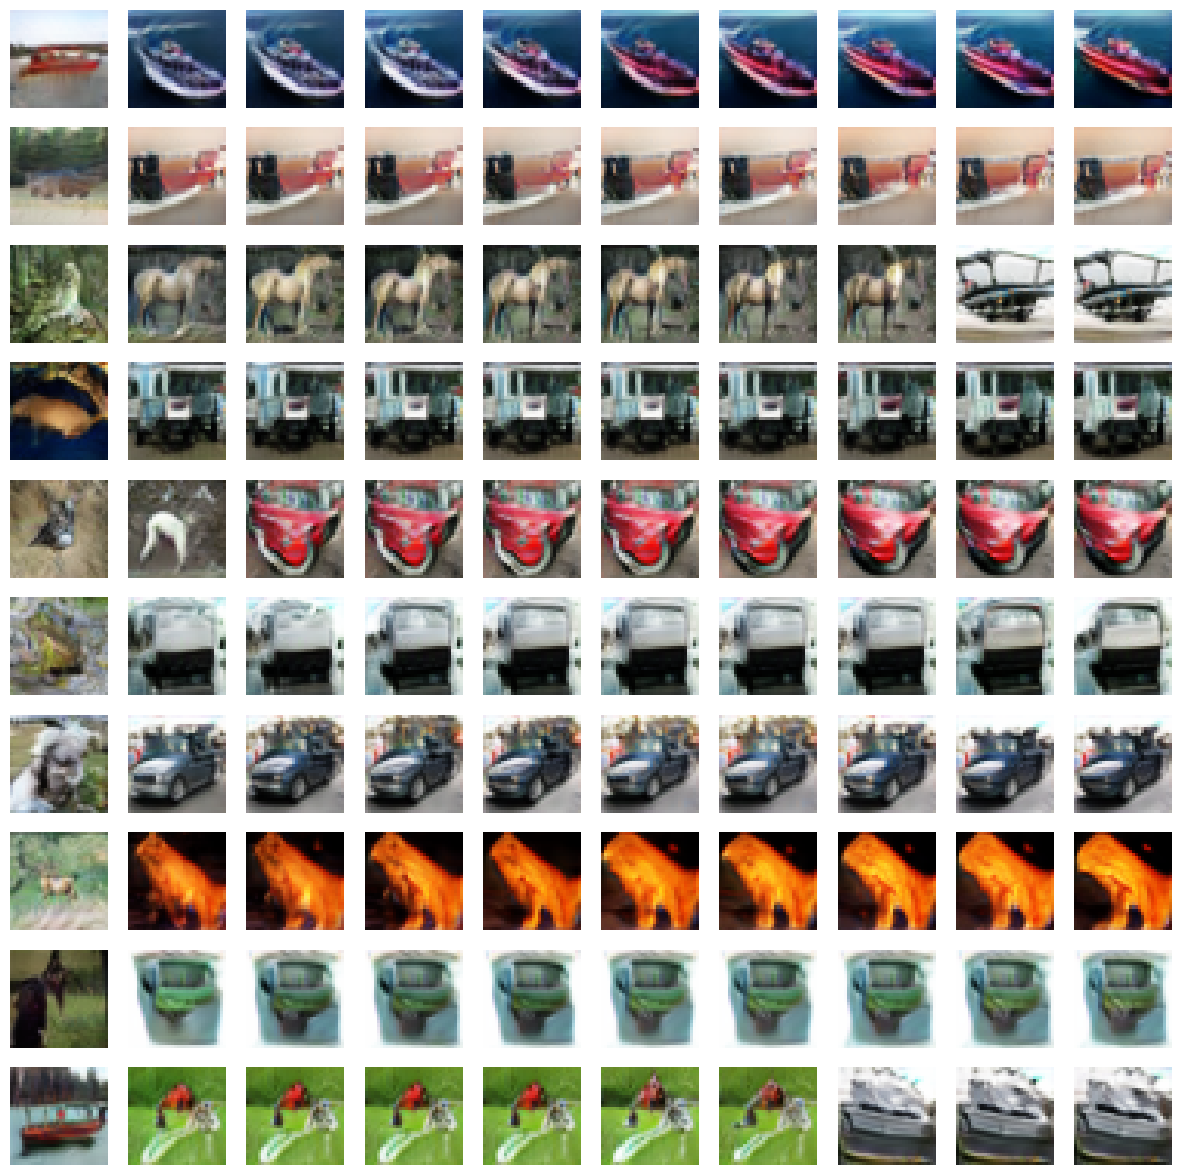

In [31]:
plt.figure(figsize=(15, 15))

for traj_i in range(10):
    for step_i in range(10):
        plt.subplot(10, 10, 10 * traj_i + step_i + 1)
        img = gen_cifar10(Samples_ex2[traj_i, step_i * 10:step_i * 10 + 1])[0].detach().cpu().numpy()
        img = (img + 1) / 2
        
        plt.axis('off')
        plt.imshow(img.transpose((1, 2, 0)))

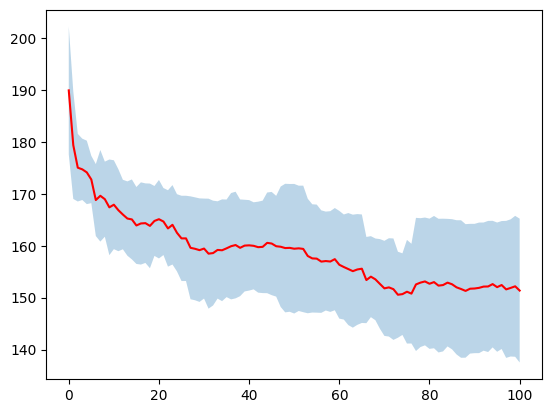

In [32]:
means = energies_ex2.mean(dim=0)
stds = energies_ex2.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='r')
plt.fill_between(np.arange(N_steps + 1), means - stds, means + stds, alpha=0.3)

### Plot all 4 pictures together

In [33]:
A = np.load('a.npy')

In [34]:
A.shape

(10, 101, 128)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 35.52it/s]


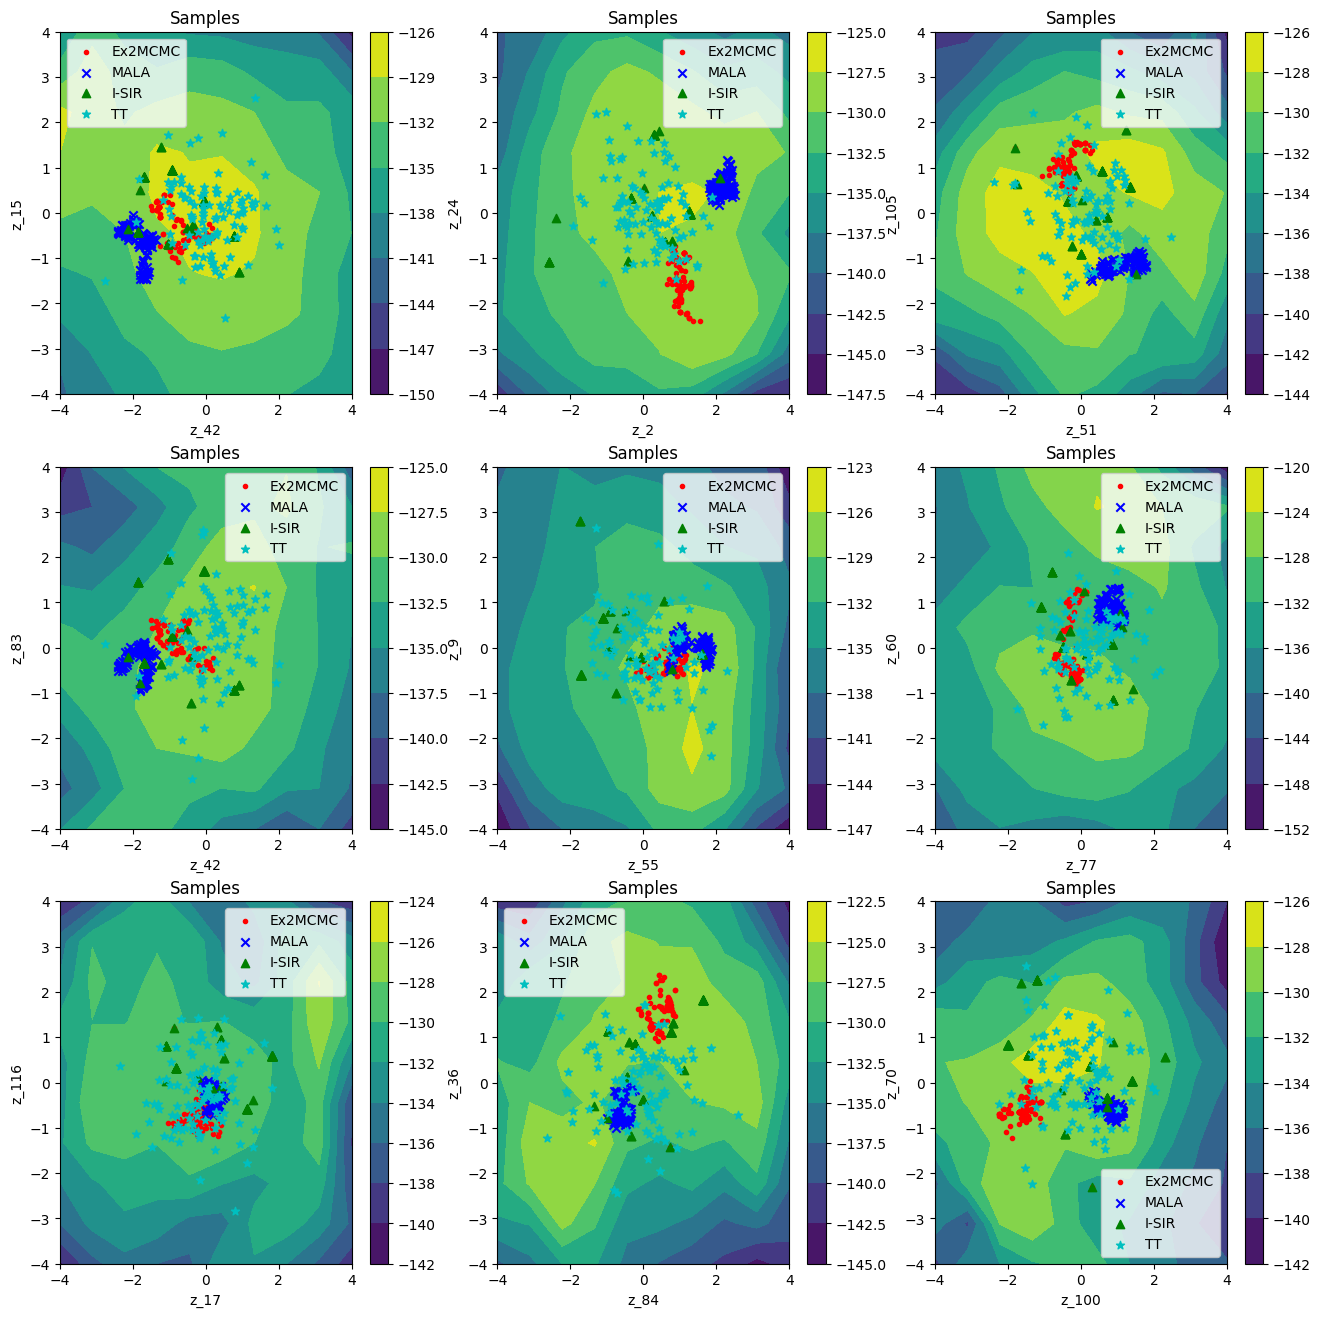

In [35]:
a = 2

plt.figure(figsize=(16, 16))

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.scatter(Samples_ex2[0, :, i1].cpu(), Samples_ex2[0, :, i2].cpu(),  c='r', marker='.', label='Ex2MCMC') 
    plt.scatter(Samples_mala[0, :, i1].cpu(), Samples_mala[0, :, i2].cpu(), c='b', marker='x', label='MALA')
    plt.scatter(Samples_isir[0, :, i1].cpu(), Samples_isir[0, :, i2].cpu(), c='g', marker='^', label='I-SIR')
    plt.scatter(A[0, :, i1], A[0,:, i2], c='c', marker='*', label='TT')
    
    plt.legend()
    
    plt.title('Samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

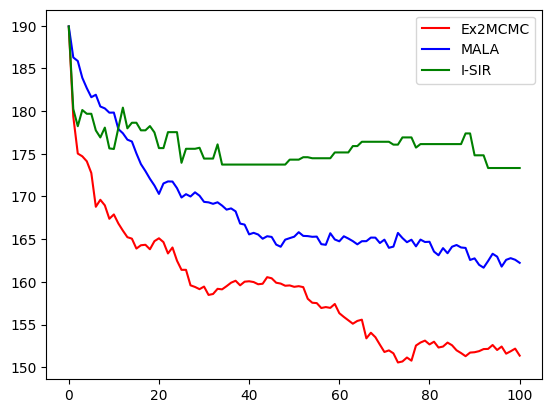

In [36]:
means = energies_ex2.mean(dim=0)
stds = energies_ex2.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='r', label='Ex2MCMC')
#plt.fill_between(np.arange(N_steps), means - stds, means + stds, color='r', alpha=0.2)


means = energies_mala.mean(dim=0)
stds = energies_mala.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='b', label='MALA')
#plt.fill_between(np.arange(N_steps), means - stds, means + stds, color='b', alpha=0.2)

means = energies_isir.mean(dim=0)
stds = energies_isir.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='g', label='I-SIR')
#plt.fill_between(np.arange(N_steps), means - stds, means + stds, color='g', alpha=0.2)



plt.legend()

In [37]:
def target_dens(z, detach=True, batch_size=256):
    """
    returns the value of a target density - mixture of the 3 gaussians 
    """
    res = []
    z = z.to(device)
    print(z.shape)
    for i in range(z.shape[0] // batch_size + (1 if z.shape[0] % batch_size else 0)):
        cur_res = -get_energy_wgan(z[batch_size * i: batch_size * (i+1)]) + 55
        
        if detach:
            cur_res = cur_res.detach()
        
        res.append(cur_res.cpu().double().exp())
    W = torch.cat(res)
    print(W.max().item(), W.min().item())
    return W

In [38]:
domain = [torch.linspace(-3, 3, 50) for _ in range(lat_size)]



In [39]:
z = torch.rand(2, 128)

target_dens(z)

torch.Size([2, 128])
2.200768579980829e-38 1.5158293571950385e-44


tensor([1.5158e-44, 2.2008e-38], dtype=torch.float64)

In [40]:
#import pickle

#with open('aaaa.pickle', 'wb') as f:
#    pickle.dump(t.cores, f)

In [41]:
#with open('a.pickle', 'rb') as f:
#    u = pickle.load(f)

In [42]:
#A = np.load('a.npy')

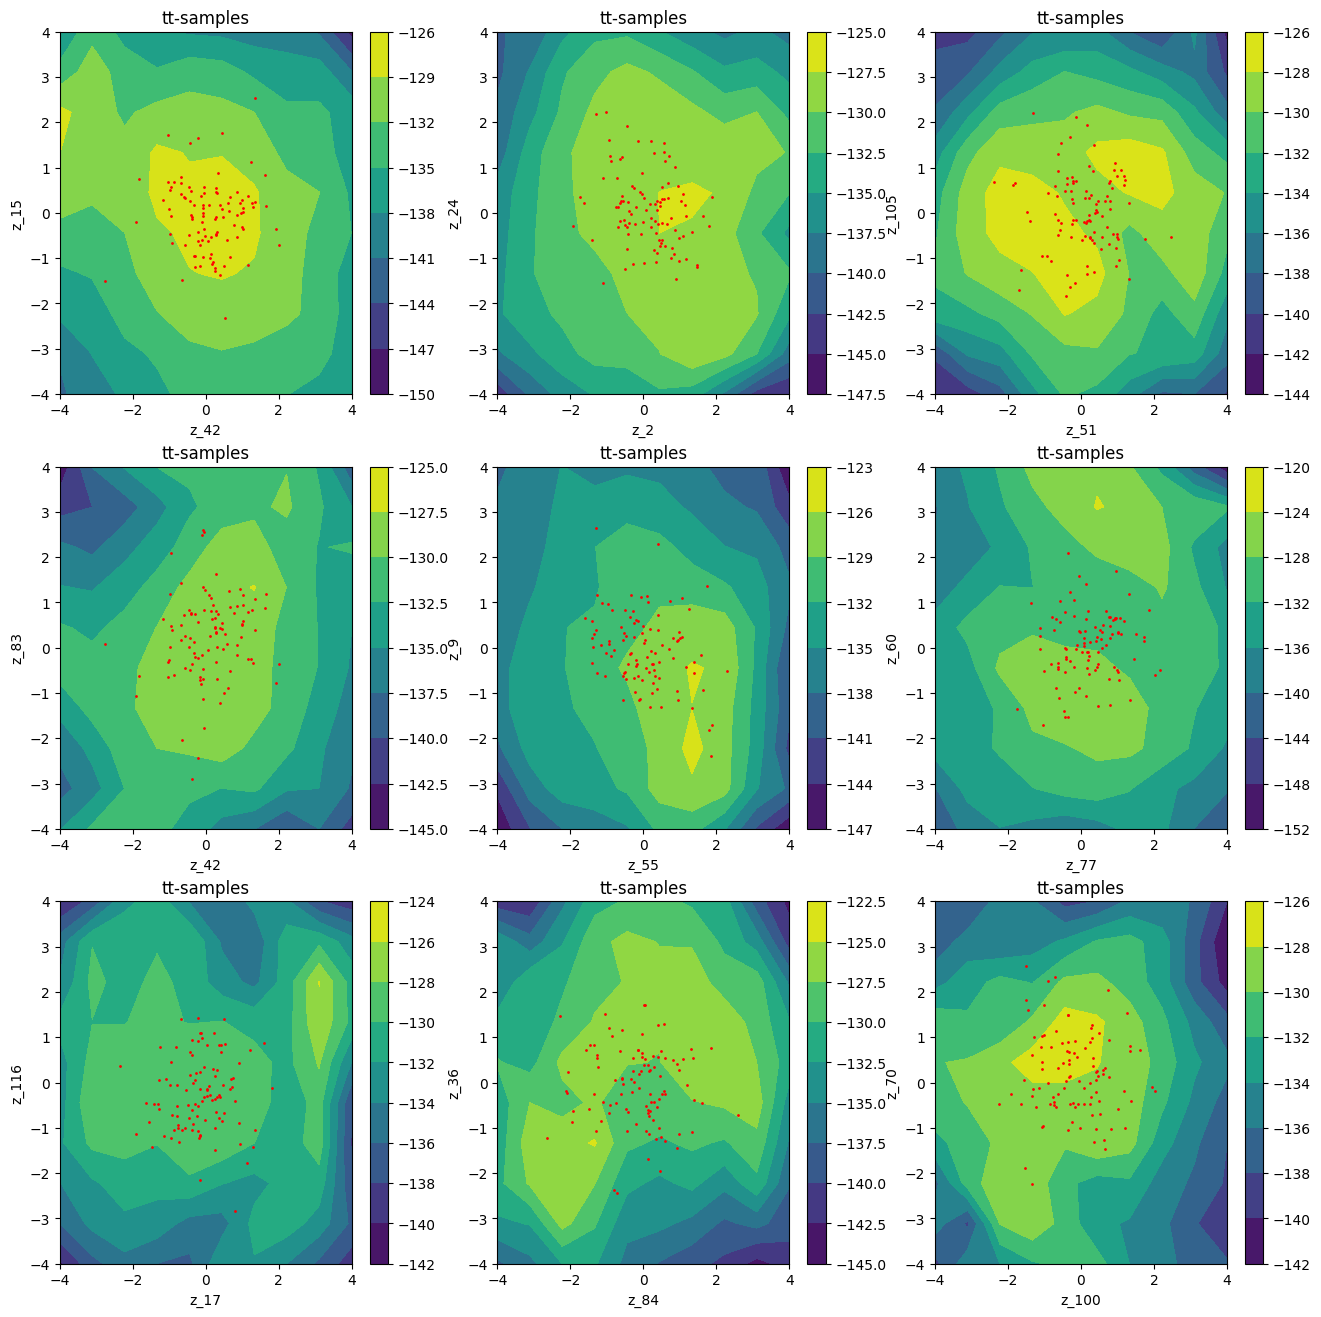

In [43]:
a = 2

plt.figure(figsize=(16, 16))

for j in range(9):
    i1, i2 = idxs[j]
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.scatter(A[0, :, i1], A[0, :, i2], s=1, c='r')
    plt.title('tt-samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

In [44]:
W = torch.tensor(A, dtype=torch.float32).to(device)
energ_tt = -log_target_dens(W.reshape(-1,128)).reshape(10, 101)
#energ_tt

In [45]:
W = torch.tensor(A, dtype=torch.float32)
W.shape

torch.Size([10, 101, 128])

In [46]:
default_prior = torch.randn((10, 101, 128), dtype=torch.float32).to(device)
energ_default = -log_target_dens(default_prior.reshape(-1, 128)).reshape(10, 101)


In [47]:
energies_ex2.shape

torch.Size([10, 101])

In [48]:
energies_mala.shape

torch.Size([10, 101])

In [49]:
energ_tt.shape

torch.Size([10, 101])

Text(0, 0.5, 'Energy')

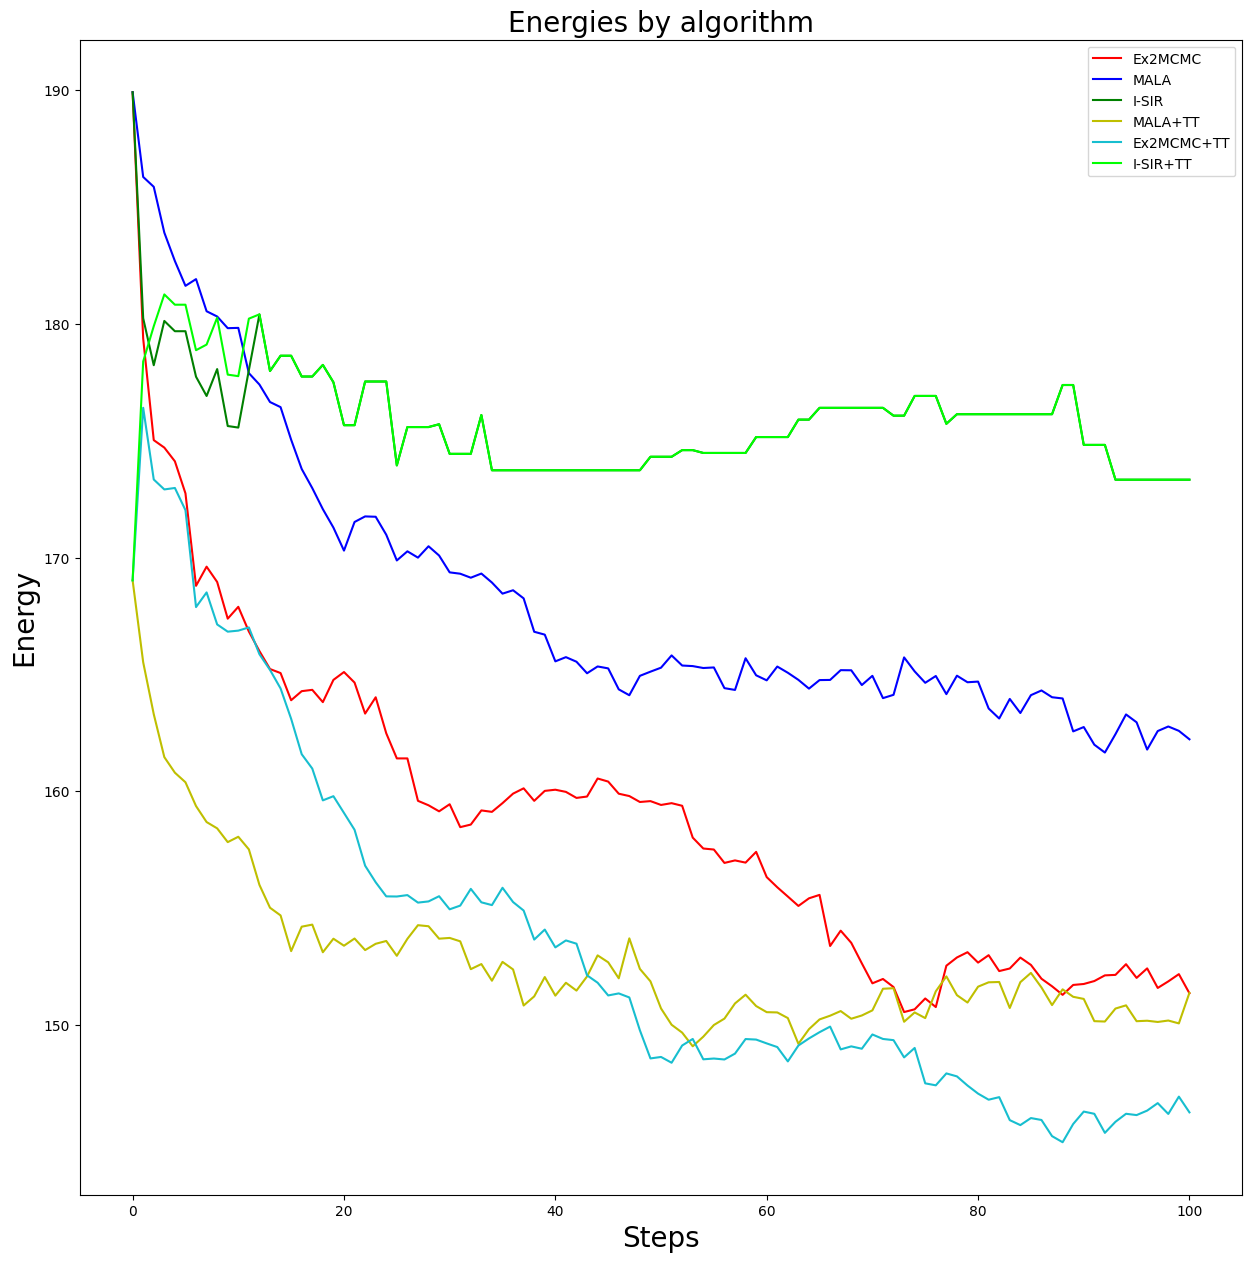

In [65]:
plt.figure(figsize=(15, 15))

means = energies_ex2.mean(dim=0)
stds = energies_ex2.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='r', label='Ex2MCMC')
#plt.fill_between(np.arange(N_steps + 1), means - stds, means + stds, color='r', alpha=0.2)


means = energies_mala.mean(dim=0)
stds = energies_mala.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='b', label='MALA')
#plt.fill_between(np.arange(N_steps), means - stds, means + stds, color='b', alpha=0.2)

means = energies_isir.mean(dim=0)
stds = energies_isir.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='g', label='I-SIR')
#plt.fill_between(np.arange(N_steps), means - stds, means + stds, color='g', alpha=0.2)

#means = energ_tt.mean(dim=0).cpu()
#stds = pd.Series(energ_tt.std(dim=0).cpu().numpy()).ewm(span=2).mean()

#plt.plot(np.arange(N_steps + 1), means.cpu(), c='m', label='TT')
#plt.fill_between(np.arange(N_steps + 1), means.numpy() - stds, means.numpy() + stds, color='g', alpha=0.2)

#means = energ_default.mean(dim=0).cpu()
#stds = pd.Series(energ_default.std(dim=0).cpu().numpy()).ewm(span=2).mean()


#plt.plot(np.arange(N_steps + 1), means.cpu(), c='k', label='default proposal')
#plt.fill_between(np.arange(N_steps + 1), means.numpy() - stds, means.numpy() + stds, color='r', alpha=0.2)

means = energies_mala_corr.mean(dim=0)
stds = energies_mala_corr.std(dim=0)

plt.plot(np.arange(N_steps + 1), means.cpu(), c='y', label='MALA+TT')


means = energies_ex2_corr.mean(dim=0)
stds = energies_ex2_corr.std(dim=0)

plt.plot(np.arange(N_steps + 1), means.cpu(), c='tab:cyan', label='Ex2MCMC+TT')

means = energies_isir_corr.mean(dim=0)
stds = energies_isir_corr.std(dim=0)

plt.plot(np.arange(N_steps + 1), means.cpu(), c='lime', label='I-SIR+TT')

plt.legend()
plt.title('Energies by algorithm', fontdict={'fontsize':20})

plt.xlabel('Steps', fontdict={'fontsize':20})
plt.ylabel('Energy', fontdict={'fontsize':20})

0      12.308068
1      11.035508
2       9.253740
3       8.621522
4       8.675519
         ...    
96      9.035022
97      9.060460
98      9.075722
99      9.084880
100     9.090374
Length: 101, dtype: float64

Corrected Ex2MCMC

In [51]:
x1 = torch.tensor(A[:, 1, :], dtype=torch.float32).to(device)

In [52]:
sigma_isir = 1.0
isir_proposal = MultivariateNormal(
    torch.zeros(lat_size).to(device), 
    (sigma_isir ** 2) * torch.eye(lat_size).to(device))

N_particles = 10

gamma = 5e-3
mala_iters = 3

stats = {'n_accepts': 0, 'sizes':0}

Samples_ex2_corr = ex2_mcmc(log_target_dens=log_target_dens, x0=x1, N_steps=N_steps, 
                       N_part=N_particles, isir_proposal=isir_proposal ,
                       gamma=gamma, mala_iters=mala_iters, stats=stats)

energies_ex2_corr = -log_target_dens(Samples_ex2_corr.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


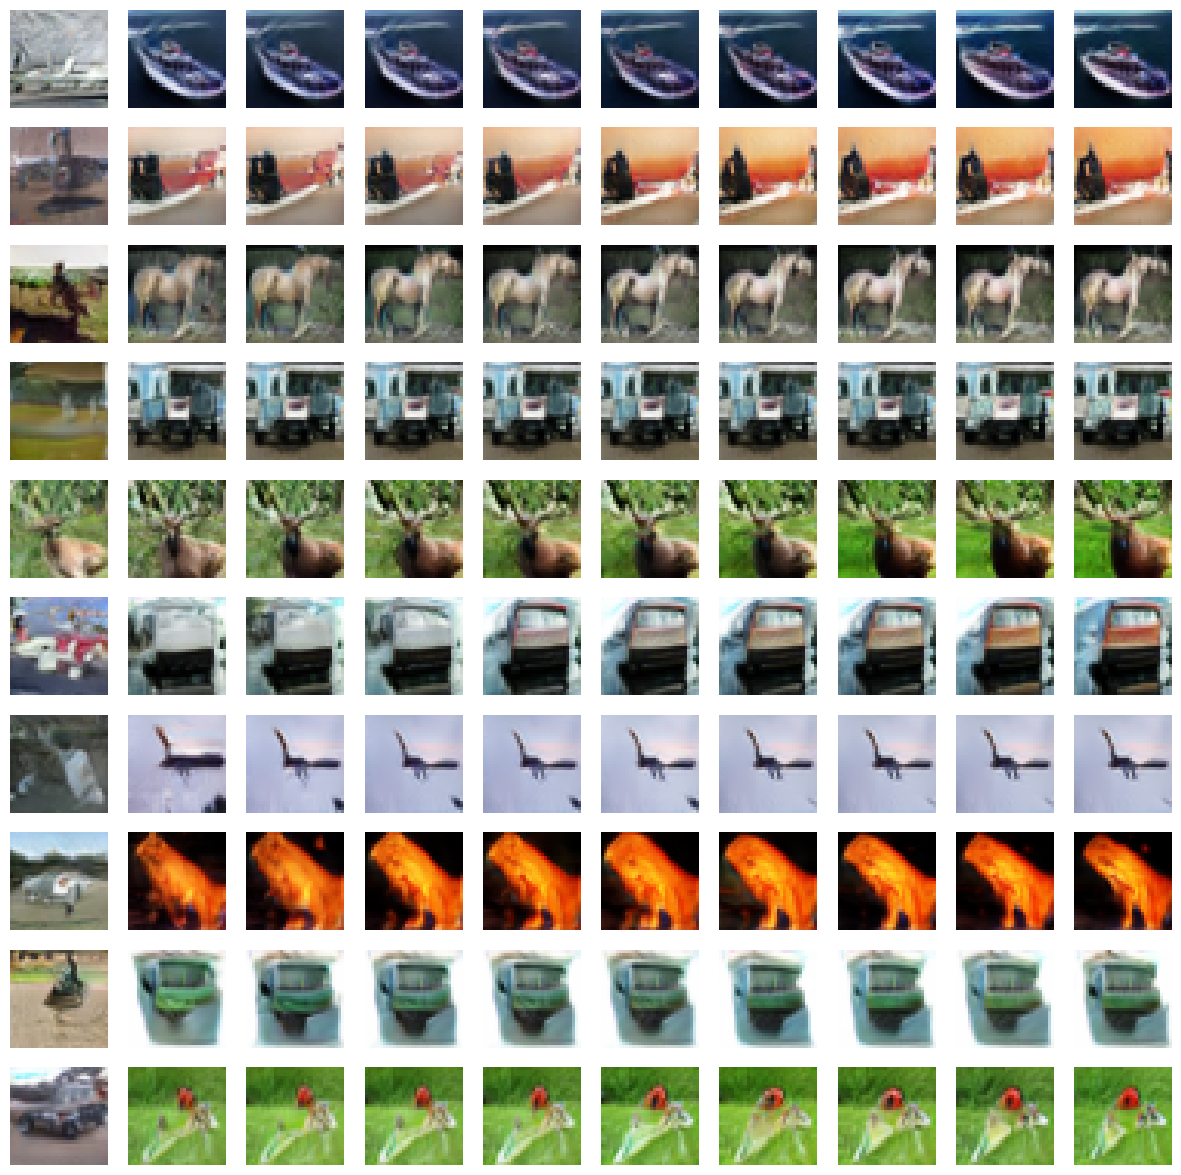

In [53]:
plt.figure(figsize=(15, 15))

for traj_i in range(10):
    for step_i in range(10):
        plt.subplot(10, 10, 10 * traj_i + step_i + 1)
        img = gen_cifar10(Samples_ex2_corr[traj_i, step_i * 10:step_i * 10 + 1])[0].detach().cpu().numpy()
        img = (img + 1) / 2
        
        plt.axis('off')
        plt.imshow(img.transpose((1, 2, 0)))

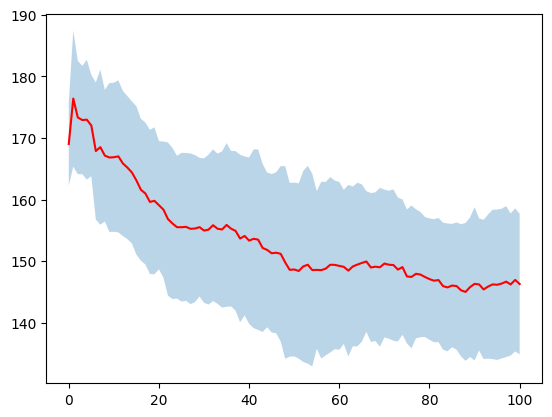

In [54]:
means = energies_ex2_corr.mean(dim=0)
stds = energies_ex2_corr.std(dim=0)

plt.plot(np.arange(N_steps + 1), means, c='r')
plt.fill_between(np.arange(N_steps + 1), means - stds, means + stds, alpha=0.3)

In [55]:

gamma = 1e-3
mala_iters = 3

stats = {'n_accepts': 0, 'sizes':0}

Samples_mala_corr = mala(log_target_dens=log_target_dens, x0=x1, N_steps=N_steps, gamma=gamma,
                    mala_iters=mala_iters, stats=stats)

energies_mala_corr = -log_target_dens(Samples_mala_corr.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.72it/s]


In [56]:
stats['n_accepts']/stats['sizes']

0.5236666666666666

In [57]:
log_target_dens

<function __main__.log_target_dens(z, detach=True, batch_size=256)>

In [58]:
stats

{'n_accepts': 1571.0, 'sizes': 3000}

In [59]:
stats['n_accepts']/(N_steps * mala_iters)

5.236666666666666

In [60]:
sigma_isir = 1.0
isir_proposal = MultivariateNormal(
    torch.zeros(lat_size).to(device), 
    (sigma_isir ** 2) * torch.eye(lat_size).to(device))

N_particles = 10

Samples_isir_corr = i_sir(log_target_dens=log_target_dens, 
                          x0=x1, N_steps=N_steps, N_part=N_particles, isir_proposal=isir_proposal)

energies_isir_corr = -log_target_dens(Samples_isir_corr.reshape(-1, lat_size)).reshape(N_samples, N_steps + 1).cpu()

100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 14.14it/s]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 19.85it/s]


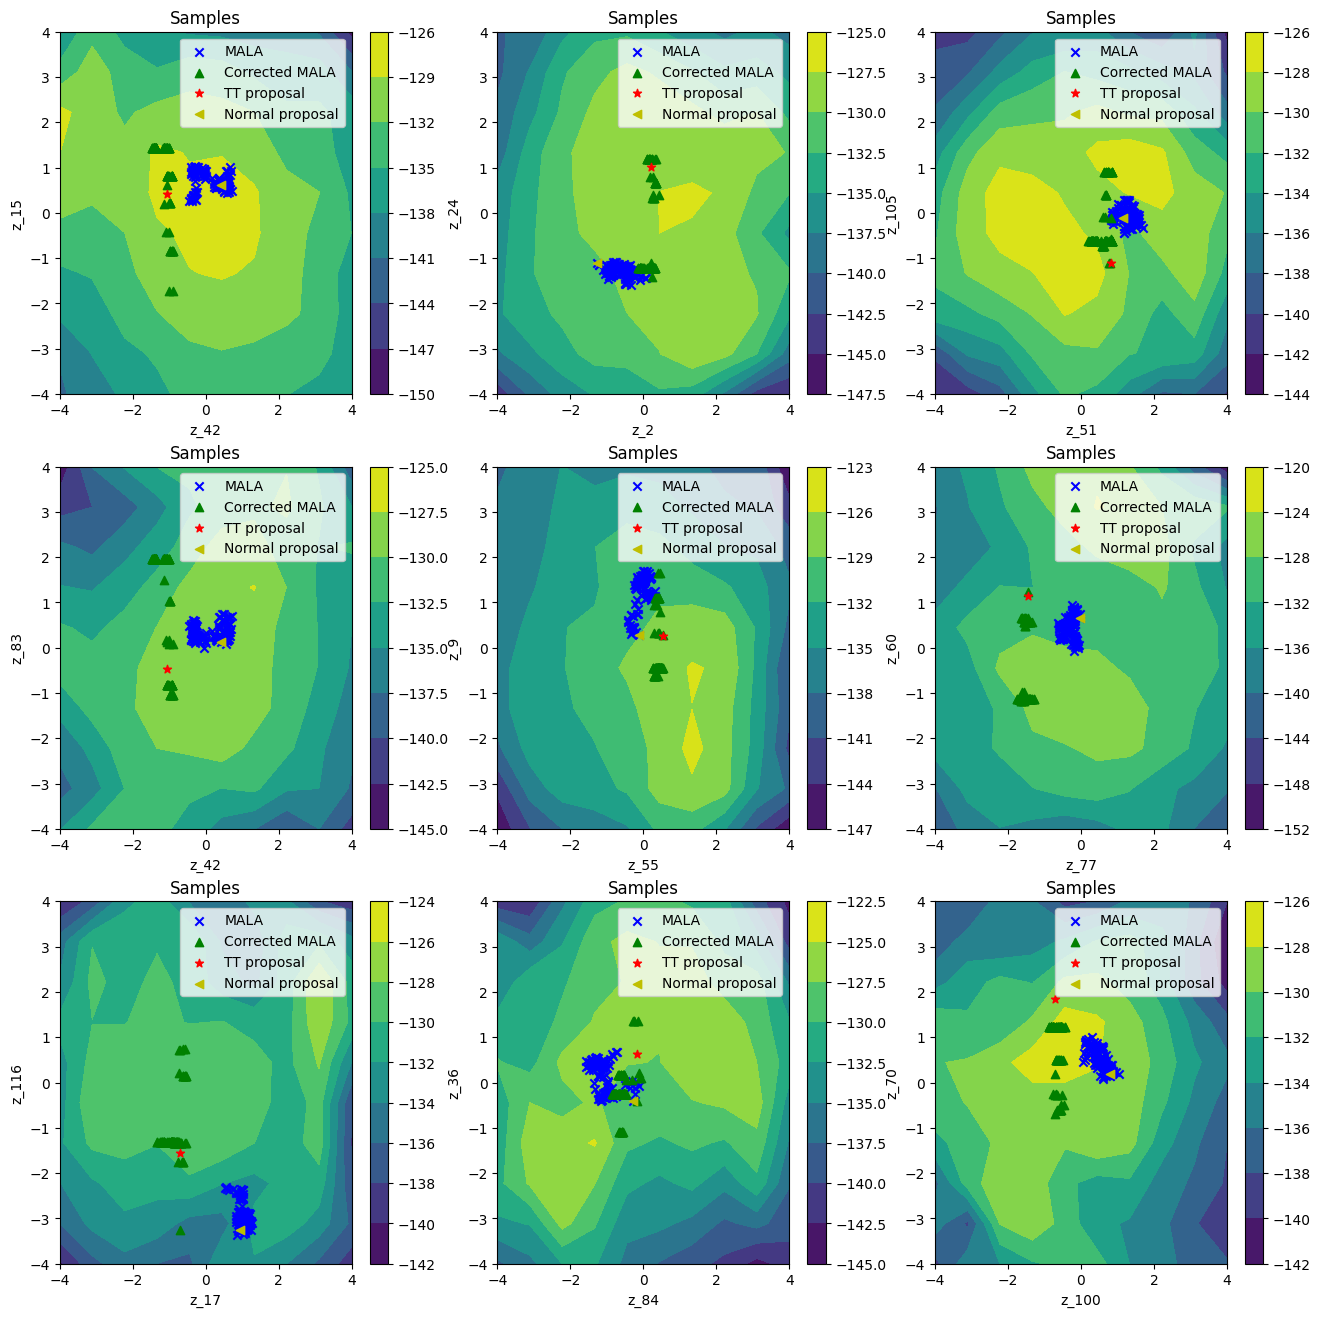

In [61]:
a = 2
k = 7
plt.figure(figsize=(16, 16))

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    #plt.scatter(Samples_ex2[0, :, i1].cpu(), Samples_ex2[0, :, i2].cpu(),  c='r', marker='.', label='Ex2MCMC') 
    plt.scatter(Samples_mala[k, :, i1].cpu(), Samples_mala[k, :, i2].cpu(), c='b', marker='x', label='MALA')
    plt.scatter(Samples_mala_corr[k, :, i1].cpu(), Samples_isir[k, :, i2].cpu(), c='g', marker='^', label='Corrected MALA')
    plt.scatter(x1[k, i1].cpu(), x1[k, i2].cpu(), c='r', marker='*', label='TT proposal')
    plt.scatter(x0[k, i1].cpu(), x0[k, i2].cpu(), c='y', marker='<', label='Normal proposal')
    #plt.scatter(A[0, :, i1], A[0,:, i2], c='c', marker='*', label='TT')
    
    plt.legend()
    
    plt.title('Samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

In [62]:
Samples_mala_corr.shape

torch.Size([10, 101, 128])

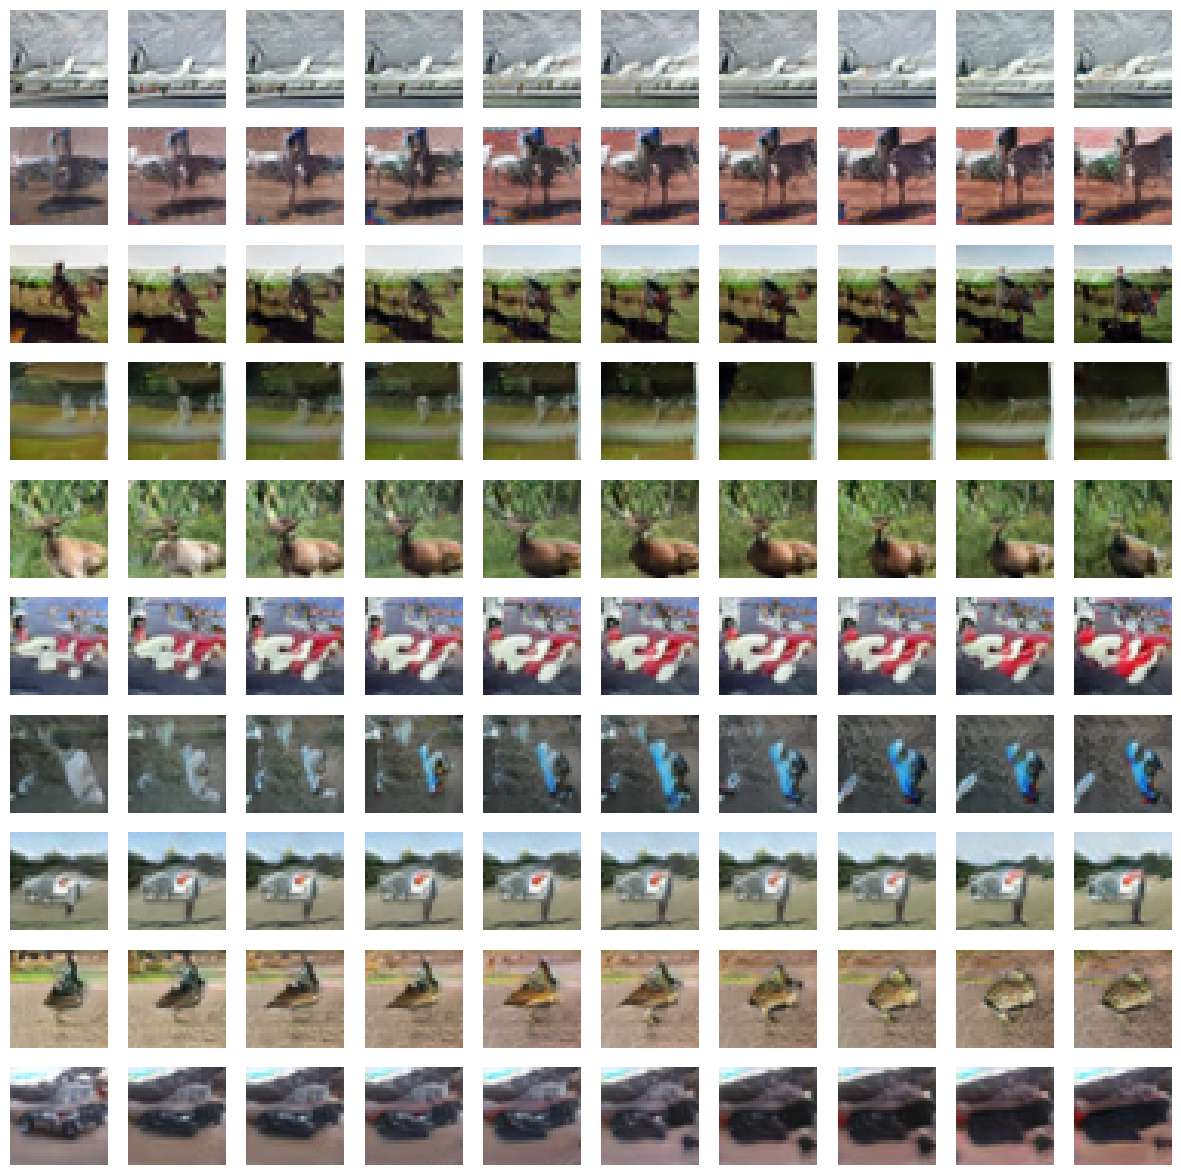

In [63]:
plt.figure(figsize=(15, 15))
for traj_i in range(10):
    for step_i in range(10):
        plt.subplot(10, 10, 10 * traj_i + step_i + 1)
        img = gen_cifar10(Samples_mala_corr[traj_i, step_i * 10:step_i * 10 + 1])[0].detach().cpu().numpy()
        img = (img + 1) / 2
        
        plt.axis('off')
        plt.imshow(img.transpose((1, 2, 0)))

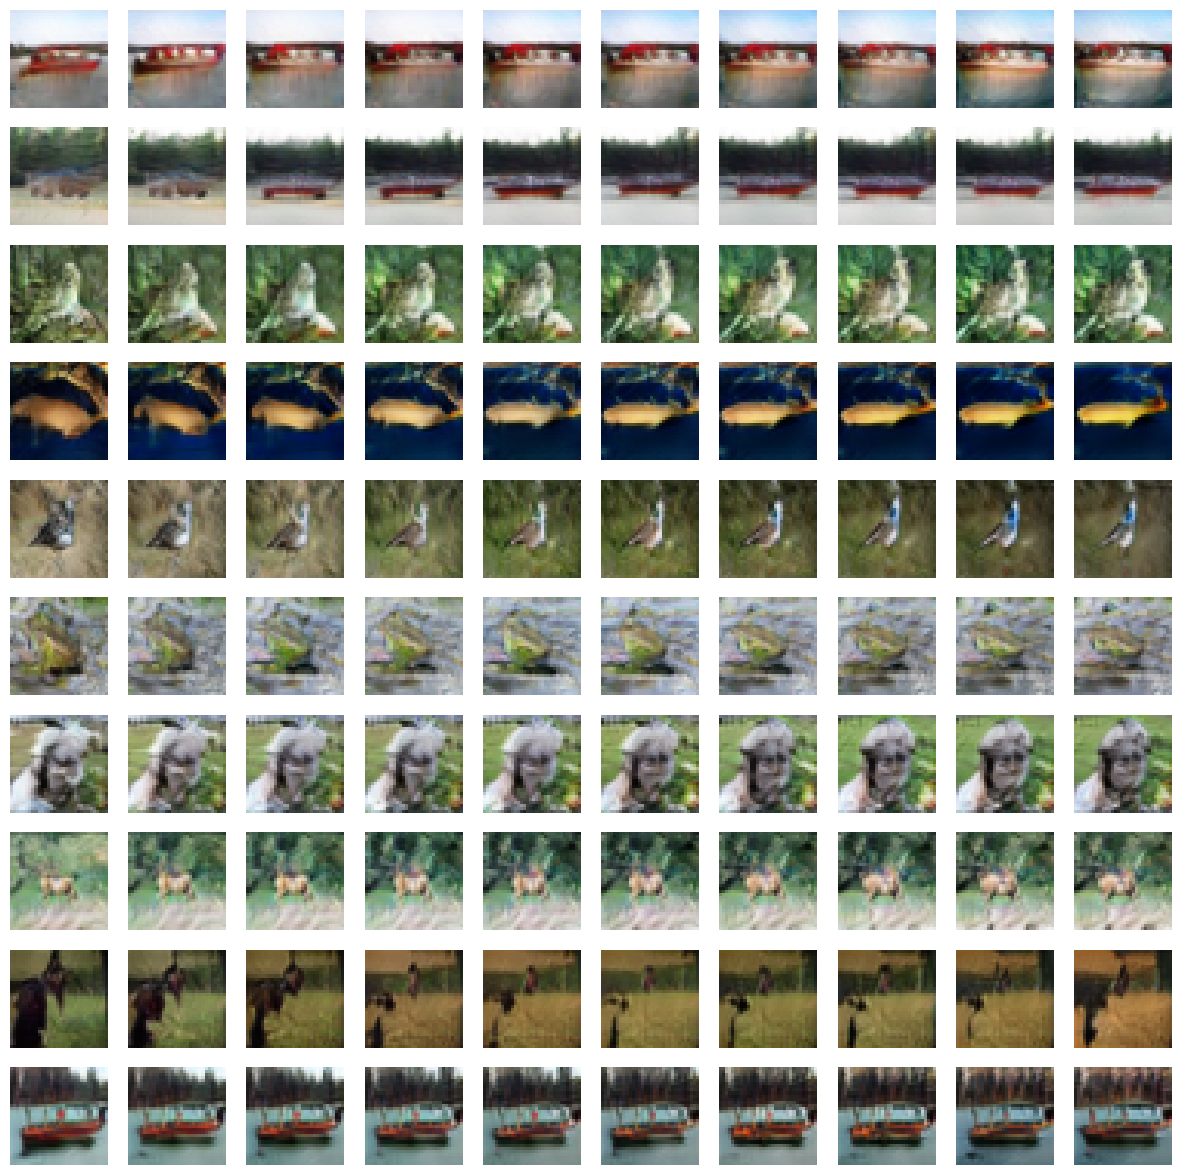

In [64]:
plt.figure(figsize=(15, 15))

for traj_i in range(10):
    for step_i in range(10):
        plt.subplot(10, 10, 10 * traj_i + step_i + 1)
        img = gen_cifar10(Samples_mala[traj_i, step_i * 10:step_i * 10 + 1])[0].detach().cpu().numpy()
        img = (img + 1) / 2
        
        plt.axis('off')
        plt.imshow(img.transpose((1, 2, 0)))